In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import csv
import pickle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Data Loading**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Information***
Attribute Information.
  1.  Sequence Name: Accession number for the SWISS-PROT database
  2.  mcg: McGeoch's method for signal sequence recognition.
  3.  gvh: von Heijne's method for signal sequence recognition.
  4.  alm: Score of the ALOM membrane spanning region prediction program.
  5.  mit: Score of discriminant analysis of the amino acid content of
	   the N-terminal region (20 residues long) of mitochondrial and 
           non-mitochondrial proteins.
  6.  erl: Presence of "HDEL" substring (thought to act as a signal for
	   retention in the endoplasmic reticulum lumen). Binary attribute.
  7.  pox: Peroxisomal targeting signal in the C-terminus.
  8.  vac: Score of discriminant analysis of the amino acid content of
           vacuolar and extracellular proteins.
  9.  nuc: Score of discriminant analysis of nuclear localization signals
	   of nuclear and non-nuclear proteins.


Class Distribution. The class is the localization site. Please see Nakai &
Kanehisa referenced above for more details.
  

  1.  CYT (cytosolic or cytoskeletal)                    463
  2.  NUC (nuclear)                                      429
  3.  MIT (mitochondrial)                                244
  4.  ME3 (membrane protein, no N-terminal signal)       163
  5.  ME2 (membrane protein, uncleaved signal)            51
  6.  ME1 (membrane protein, cleaved signal)              44
  7.  EXC (extracellular)                                 37
  8.  VAC (vacuolar)                                      30
  9.  POX (peroxisomal)                                   20
  10. ERL (endoplasmic reticulum lumen)                    5



In [4]:
dataSet = 'yeast_05679_4'
filePath = '/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/'+dataSet+'.csv'
data = pd.read_csv(filePath)
data

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


In [5]:
data.groupby('name').count()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
name,,,,,,,,
CYT,463,463,463,463,463,463,463,463
ERL,5,5,5,5,5,5,5,5
EXC,35,35,35,35,35,35,35,35
ME1,44,44,44,44,44,44,44,44
ME2,51,51,51,51,51,51,51,51
ME3,163,163,163,163,163,163,163,163
MIT,244,244,244,244,244,244,244,244
NUC,429,429,429,429,429,429,429,429
POX,20,20,20,20,20,20,20,20


In [6]:
data = data.replace(np.nan,0.0)

In [7]:
data.iloc[3,3]

0.13

In [9]:
#_05679_4
for i in range(len(data)):
  if data.iloc[i,8]=='ME2':
    data.iloc[i,8] = 1.0
  elif data.iloc[i,8]=='ME3' or data.iloc[i,8]=='MIT' or data.iloc[i,8]=='POX' or data.iloc[i,8]=='VAC':
    data.iloc[i,8] = 0.0
  # else:
  #   data = data.drop(data.index[i],inplace=True)
data

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,0.0
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,0.0
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,0.0
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,0.0
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,1.0
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,1.0
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


In [24]:
#Converting list to csv file
d = []
for i in range(len(data)):
  if data.iloc[i,8]==0.0 or data.iloc[i,8]==1.0:
    d.append(data.iloc[i])

d = pd.DataFrame(d)  
d.to_csv('d.csv') 
data = d
data

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,0.0
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,0.0
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,0.0
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,0.0
6,0.50,0.54,0.48,0.65,0.5,0.0,0.53,0.22,0.0
...,...,...,...,...,...,...,...,...,...
1469,0.38,0.47,0.47,0.18,0.5,0.0,0.44,0.26,0.0
1470,0.63,0.57,0.50,0.48,0.5,0.0,0.51,0.22,0.0
1471,0.51,0.45,0.62,0.25,0.5,0.0,0.59,0.22,0.0
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,1.0


In [25]:
from random import shuffle
train, test= train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
print(train.shape,test.shape)

(406, 9) (102, 9)


In [26]:
train.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
859,0.60,0.59,0.47,0.47,0.5,0.0,0.53,0.22,0.0
376,0.20,0.34,0.33,0.10,0.5,0.0,0.48,0.31,0.0
1431,0.51,0.46,0.41,0.36,0.5,0.0,0.49,0.22,0.0
1377,0.45,0.50,0.43,0.16,0.5,0.0,0.52,0.28,0.0
1200,0.28,0.18,0.72,0.26,0.5,0.0,0.49,0.25,0.0


In [29]:
features = train.columns[0:-1]
features

Index(['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc'], dtype='object')

In [31]:
X = data[features]
y = data['name']
X

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22
6,0.50,0.54,0.48,0.65,0.5,0.0,0.53,0.22
...,...,...,...,...,...,...,...,...
1469,0.38,0.47,0.47,0.18,0.5,0.0,0.44,0.26
1470,0.63,0.57,0.50,0.48,0.5,0.0,0.51,0.22
1471,0.51,0.45,0.62,0.25,0.5,0.0,0.59,0.22
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22


# **Data Split (Major and Minor)**

In [32]:
for(name), group in train.groupby(['name']):
  group.to_csv(f'{name}.csv', index=False)
# print(pd.read_csv("0.0.csv"))
# print(pd.read_csv("1.0.csv"))
train_zero = pd.read_csv("0.0.csv")
train_one = pd.read_csv("1.0.csv")
train_zero

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.60,0.59,0.47,0.47,0.5,0.0,0.53,0.22,0.0
1,0.20,0.34,0.33,0.10,0.5,0.0,0.48,0.31,0.0
2,0.51,0.46,0.41,0.36,0.5,0.0,0.49,0.22,0.0
3,0.45,0.50,0.43,0.16,0.5,0.0,0.52,0.28,0.0
4,0.28,0.18,0.72,0.26,0.5,0.0,0.49,0.25,0.0
...,...,...,...,...,...,...,...,...,...
359,0.36,0.68,0.38,0.08,0.5,0.0,0.53,0.25,0.0
360,0.49,0.44,0.45,0.55,0.5,0.0,0.48,0.22,0.0
361,0.45,0.53,0.51,0.42,0.5,0.0,0.52,0.22,0.0
362,0.48,0.58,0.58,0.12,0.5,0.0,0.49,0.22,0.0


In [33]:
train_one

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.86,0.74,0.51,0.40,0.5,0.0,0.55,0.22,1.0
1,0.74,0.75,0.58,0.47,0.5,0.0,0.40,0.35,1.0
2,0.97,0.71,0.29,0.42,0.5,0.0,0.35,0.22,1.0
3,0.88,0.75,0.41,0.36,0.5,0.0,0.43,0.22,1.0
4,0.57,0.59,0.44,0.16,0.5,0.0,0.52,0.22,1.0
5,0.79,0.57,0.41,0.28,0.5,0.0,0.59,0.22,1.0
6,0.83,0.58,0.33,0.04,0.5,0.0,0.53,0.22,1.0
7,0.54,0.42,0.41,0.16,0.5,0.0,0.52,0.22,1.0
8,0.71,0.56,0.39,0.27,0.5,0.0,0.52,0.22,1.0
9,0.94,0.60,0.33,0.49,0.5,0.0,0.54,0.22,1.0


In [34]:
train_zero.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/train_zero.csv')
train_one.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/train_one.csv')


In [35]:
major_class = train_zero
minor_class = train_one

In [36]:
# before scaling the min and max values for both alcohol and malic acid are different 

minor_class.describe().T  


,count,mean,std,min,25%,50%,75%,max
mcg,42.0,0.714048,0.169131,0.34,0.6400,0.750,0.8300,0.97
gvh,42.0,0.594762,0.126534,0.34,0.5125,0.570,0.7050,0.90
alm,42.0,0.422381,0.079689,0.27,0.3650,0.410,0.4600,0.60
mit,42.0,0.280952,0.128382,0.04,0.1825,0.265,0.3600,0.57
erl,42.0,0.511905,0.077152,0.50,0.5000,0.500,0.5000,1.00
pox,42.0,0.000000,0.000000,0.00,0.0000,0.000,0.0000,0.00
vac,42.0,0.507857,0.066242,0.30,0.5000,0.520,0.5400,0.61
nuc,42.0,0.242857,0.049745,0.22,0.2200,0.220,0.2425,0.47
name,42.0,1.000000,0.000000,1.00,1.0000,1.000,1.0000,1.00


In [37]:
major_class.describe().T

,count,mean,std,min,25%,50%,75%,max
mcg,364.0,0.490879,0.111468,0.20,0.4200,0.49,0.5625,0.81
gvh,364.0,0.518736,0.107227,0.18,0.4500,0.52,0.5900,1.00
alm,364.0,0.461593,0.099808,0.21,0.3800,0.47,0.5400,0.72
mit,364.0,0.315797,0.167214,0.08,0.1800,0.27,0.4400,0.87
erl,364.0,0.501374,0.026207,0.50,0.5000,0.50,0.5000,1.00
pox,364.0,0.020989,0.126957,0.00,0.0000,0.00,0.0000,0.83
vac,364.0,0.508022,0.041778,0.26,0.4875,0.51,0.5300,0.69
nuc,364.0,0.251758,0.071683,0.11,0.2200,0.22,0.2625,0.83
name,364.0,0.000000,0.000000,0.00,0.0000,0.00,0.0000,0.00


In [38]:
n = len(data.iloc[0])
n

9

# **Auto Encoder**

In [39]:
import keras
from keras import layers

# This is the size of our encoded representations
n = len(data.iloc[0]) - 1
encoding_dim = n # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(n,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation=None)(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(n, activation=None)(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [40]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


In [41]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [42]:
autoencoder.compile(optimizer='adam', loss='mse')

In [43]:
x_train = minor_class[features]
x_test = major_class[features]
y_train = minor_class['name']
y_test = major_class['name']

# **Data Scaling**

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()    # create an object of class

scaler.fit(x_train)       #  fit on training i/p data
x_train_scaled = scaler.transform(x_train)    # transform model on both traing and testing data

scaler.fit(x_test)
x_test_scaled = scaler.transform(x_test)


In [45]:
# convert the numpy array after transform into a dataframe
x_train_scaled = pd.DataFrame(x_train_scaled,columns = x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled,columns = x_test.columns)
#x_test_scaled = pd.DataFrame(x_test_scaled,columns = x_test.columns)


In [46]:
x_train.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_train.csv')
x_test.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_test.csv')
x_train_scaled.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_train_scaled.csv')
x_test_scaled.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_test_scaled.csv')


In [47]:
x_train.shape

(42, 8)

In [48]:
x_test.shape

(364, 8)

In [ ]:
x_train

In [ ]:
x_test

In [ ]:
x_train_scaled

In [ ]:
x_test_scaled

In [53]:
autoencoder.fit(x_train_scaled, x_train_scaled,
                epochs=50,
                batch_size=8,
                shuffle=True,
                validation_data=(x_train_scaled, x_train_scaled))

Epoch 1/50
6/6 [==============================] - 1s 36ms/step - loss: 0.7947 - val_loss: 0.7431
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 0.7174 - val_loss: 0.6731
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 0.6506 - val_loss: 0.6098
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.5895 - val_loss: 0.5543
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.5354 - val_loss: 0.5050
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4896 - val_loss: 0.4599
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4457 - val_loss: 0.4213
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 0.4076 - val_loss: 0.3868
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3755 - val_loss: 0.3556
Epoch 10/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3447 - val_loss: 0.3275
Epoch 11/50
6/6 [===================

In [54]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test_scaled)
#decoded_imgs = decoder.predict(encoded_imgs)
encoded_imgs

12/12 [==============================] - 0s 2ms/step


array([[ 0.3869417 , -0.21946463,  0.08244225, ...,  0.40995032,
         0.05849029, -0.00420037],
       [ 0.18498722, -0.0182905 , -0.32794172, ...,  0.25123674,
         0.07326634,  0.15953389],
       [ 0.29880357, -0.10244852,  0.04557128, ...,  0.33434516,
         0.05300136,  0.00344387],
       ...,
       [ 0.30151853, -0.28705132, -0.02854676, ...,  0.47744894,
         0.03997631,  0.02168131],
       [ 0.25646672, -0.14991647, -0.0747745 , ...,  0.43323576,
         0.30131358,  0.17842257],
       [ 0.03197061, -0.25539777, -0.13971174, ...,  0.57145464,
         0.21368922,  0.1468572 ]], dtype=float32)

# **Euclidean Distance**

In [55]:
x_test_scaled_euclidean = x_test_scaled
x_test_scaled_euclidean.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/x_test_scaled_euclidean.csv')
x_test_scaled_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.655738,0.500000,0.509804,0.493671,0.0,0.0,0.627907,0.152778
1,0.000000,0.195122,0.235294,0.025316,0.0,0.0,0.511628,0.277778
2,0.508197,0.341463,0.392157,0.354430,0.0,0.0,0.534884,0.152778
3,0.409836,0.390244,0.431373,0.101266,0.0,0.0,0.604651,0.236111
4,0.131148,0.000000,1.000000,0.227848,0.0,0.0,0.534884,0.194444
...,...,...,...,...,...,...,...,...
359,0.262295,0.609756,0.333333,0.000000,0.0,0.0,0.627907,0.194444
360,0.475410,0.317073,0.470588,0.594937,0.0,0.0,0.511628,0.152778
361,0.409836,0.426829,0.588235,0.430380,0.0,0.0,0.604651,0.152778
362,0.459016,0.487805,0.725490,0.050633,0.0,0.0,0.534884,0.152778


In [56]:
new_col = []
#print(len(x_test_scaled.iloc[0]))
for i in range(len(x_test_scaled)):
  tot = 0
  for j in range(len(x_test_scaled.iloc[i])):
    a = (x_test_scaled.iloc[i,j] - encoded_imgs[i][j])*(x_test_scaled.iloc[i,j] - encoded_imgs[i][j])
    tot = tot + a
  new_col.append(tot)
#print(len(new_col))
new_col

[2.2763641940613697,
 0.7574636476194798,
 1.2341058588169733,
 1.1881734032323858,
 2.458731880042138,
 0.7452269968347294,
 2.176611786851568,
 3.1230510138540306,
 1.4345610088389775,
 1.1548406698397145,
 1.6133368456065205,
 1.2595986689627823,
 1.117705858768251,
 1.1785285457582602,
 2.4322494800691428,
 2.9876976239557993,
 1.7814550659554143,
 0.8775910733316147,
 2.349910740116486,
 1.3739247910937813,
 1.7089832168941823,
 3.558711092652774,
 2.177205484076531,
 1.670882253795439,
 2.05230778908895,
 0.7784898373426836,
 1.10159894365399,
 1.685361947030571,
 0.43270546893798173,
 1.677839062529075,
 2.1459137814003886,
 1.3898386882578497,
 1.89881551777596,
 1.2864204992604975,
 3.29025559559619,
 1.1998228809656086,
 2.4143767132840077,
 2.266869857375164,
 1.1795996294888833,
 2.6999840596457023,
 1.028238271908039,
 2.6953795722235583,
 0.6520553611313173,
 2.3884969251624995,
 3.3182777819312923,
 1.0015478469172172,
 3.567475423367211,
 2.501957383609338,
 1.448786133

In [57]:
x_test_scaled_euclidean['euclidean_distance'] = new_col
#x_test_scaled_euclidean = x_test_scaled_euclidean.drop(['Unnamed: 0'], axis=1)
x_test_scaled_euclidean.to_csv('x_test_scaled_euclidean.csv')
x_test_scaled_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc,euclidean_distance
0,0.655738,0.500000,0.509804,0.493671,0.0,0.0,0.627907,0.152778,2.276364
1,0.000000,0.195122,0.235294,0.025316,0.0,0.0,0.511628,0.277778,0.757464
2,0.508197,0.341463,0.392157,0.354430,0.0,0.0,0.534884,0.152778,1.234106
3,0.409836,0.390244,0.431373,0.101266,0.0,0.0,0.604651,0.236111,1.188173
4,0.131148,0.000000,1.000000,0.227848,0.0,0.0,0.534884,0.194444,2.458732
...,...,...,...,...,...,...,...,...,...
359,0.262295,0.609756,0.333333,0.000000,0.0,0.0,0.627907,0.194444,1.586752
360,0.475410,0.317073,0.470588,0.594937,0.0,0.0,0.511628,0.152778,1.968327
361,0.409836,0.426829,0.588235,0.430380,0.0,0.0,0.604651,0.152778,2.318259
362,0.459016,0.487805,0.725490,0.050633,0.0,0.0,0.534884,0.152778,1.920020


# **Sorting Data Based on Euclidean Distance**

In [59]:
# importing pandas package
import pandas as pandasForSortingCSV
# assign dataset
csvData = x_test_scaled_euclidean
# displaying unsorted data frame
print("\nBefore sorting:")
csvData
# sort data frame
csvData.sort_values(csvData.columns[n], axis=0, ascending=[False], inplace=True)
# displaying sorted data frame
print("\nAfter sorting:")
csvData


Before sorting:

After sorting:


,mcg,gvh,alm,mit,erl,pox,vac,nuc,euclidean_distance
181,0.327869,0.609756,0.568627,0.936709,0.0,0.0,0.418605,0.347222,5.384717
95,0.409836,0.670732,0.509804,0.721519,0.0,0.0,0.651163,0.444444,4.797528
180,0.311475,1.000000,0.333333,0.417722,0.0,0.0,0.558140,0.222222,4.734744
248,0.442623,0.439024,0.627451,0.873418,0.0,0.0,0.604651,0.347222,4.469766
132,0.196721,0.609756,0.588235,0.101266,0.0,1.0,0.674419,0.152778,4.370035
...,...,...,...,...,...,...,...,...,...
252,0.081967,0.207317,0.019608,0.126582,0.0,0.0,0.465116,0.152778,0.464897
86,0.196721,0.134146,0.156863,0.000000,0.0,0.0,0.604651,0.152778,0.450256
28,0.311475,0.317073,0.137255,0.050633,0.0,0.0,0.465116,0.222222,0.432705
168,0.360656,0.121951,0.235294,0.189873,0.0,0.0,0.302326,0.208333,0.365166


# **NUS1 Data**

In [60]:
final_data_without_euclidean = csvData.iloc[0:len(minor_class)]
final_data_without_euclidean = final_data_without_euclidean.drop(['euclidean_distance'], axis=1)
final_data_without_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc
181,0.327869,0.609756,0.568627,0.936709,0.0,0.0,0.418605,0.347222
95,0.409836,0.670732,0.509804,0.721519,0.0,0.0,0.651163,0.444444
180,0.311475,1.000000,0.333333,0.417722,0.0,0.0,0.558140,0.222222
248,0.442623,0.439024,0.627451,0.873418,0.0,0.0,0.604651,0.347222
132,0.196721,0.609756,0.588235,0.101266,0.0,1.0,0.674419,0.152778
197,0.442623,0.573171,0.647059,0.683544,0.0,0.0,0.627907,0.347222
99,0.409836,0.500000,0.627451,0.835443,0.0,0.0,0.488372,0.194444
320,0.655738,0.402439,0.764706,0.379747,0.0,1.0,0.604651,0.180556
134,0.508197,0.402439,0.431373,1.000000,0.0,0.0,0.604651,0.152778
348,0.295082,0.341463,0.607843,0.848101,0.0,0.0,0.558140,0.208333


In [61]:
data_with_nus1 = x_train_scaled
data_without_nus1 = x_train_scaled
data_with_nus1

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.825397,0.714286,0.727273,0.679245,0.0,0.0,0.806452,0.00
1,0.634921,0.732143,0.939394,0.811321,0.0,0.0,0.322581,0.52
2,1.000000,0.660714,0.060606,0.716981,0.0,0.0,0.161290,0.00
3,0.857143,0.732143,0.424242,0.603774,0.0,0.0,0.419355,0.00
4,0.365079,0.446429,0.515152,0.226415,0.0,0.0,0.709677,0.00
5,0.714286,0.410714,0.424242,0.452830,0.0,0.0,0.935484,0.00
6,0.777778,0.428571,0.181818,0.000000,0.0,0.0,0.741935,0.00
7,0.317460,0.142857,0.424242,0.226415,0.0,0.0,0.709677,0.00
8,0.587302,0.392857,0.363636,0.433962,0.0,0.0,0.709677,0.00
9,0.952381,0.464286,0.181818,0.849057,0.0,0.0,0.774194,0.00


In [74]:
new_one = np.ones(len(final_data_without_euclidean))   #Adding target column in nus1
#final_data_without_euclidean
final_data_without_euclidean['target'] = new_one
#final_data_without_euclidean = final_data_without_euclidean.drop(['Unnamed: 0'], axis=1)
final_data_without_euclidean.to_csv('final_data_without_euclidean.csv')
final_data_without_euclidean

new_zero = np.zeros(len(data_with_nus1))      #Adding target column in minor class
data_with_nus1['target'] = new_zero
data_with_nus1.to_csv('data_with_nus1.csv')
data_with_nus1


#NUS1 data
nus1 = pd.concat(map(pd.read_csv, ['final_data_without_euclidean.csv', 'data_with_nus1.csv']), ignore_index=True)
nus1 = nus1.drop(['Unnamed: 0'], axis=1)
nus1.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/nus1.csv')
nus1

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.327869,0.609756,0.568627,0.936709,0.0,0.0,0.418605,0.347222,1.0
1,0.409836,0.670732,0.509804,0.721519,0.0,0.0,0.651163,0.444444,1.0
2,0.311475,1.000000,0.333333,0.417722,0.0,0.0,0.558140,0.222222,1.0
3,0.442623,0.439024,0.627451,0.873418,0.0,0.0,0.604651,0.347222,1.0
4,0.196721,0.609756,0.588235,0.101266,0.0,1.0,0.674419,0.152778,1.0
...,...,...,...,...,...,...,...,...,...
79,0.746032,1.000000,0.363636,0.698113,0.0,0.0,0.741935,0.000000,0.0
80,0.190476,0.232143,0.515152,0.264151,1.0,0.0,0.516129,0.000000,0.0
81,0.000000,0.071429,0.545455,0.283019,0.0,0.0,0.677419,0.000000,0.0
82,0.523810,0.410714,0.272727,0.283019,0.0,0.0,0.838710,0.000000,0.0


# **Original Data (Without NUS1)**

In [63]:
final_data_org_without_euclidean = csvData
final_data_org_without_euclidean = final_data_org_without_euclidean.drop(['euclidean_distance'], axis=1)
final_data_org_without_euclidean

,mcg,gvh,alm,mit,erl,pox,vac,nuc
181,0.327869,0.609756,0.568627,0.936709,0.0,0.0,0.418605,0.347222
95,0.409836,0.670732,0.509804,0.721519,0.0,0.0,0.651163,0.444444
180,0.311475,1.000000,0.333333,0.417722,0.0,0.0,0.558140,0.222222
248,0.442623,0.439024,0.627451,0.873418,0.0,0.0,0.604651,0.347222
132,0.196721,0.609756,0.588235,0.101266,0.0,1.0,0.674419,0.152778
...,...,...,...,...,...,...,...,...
252,0.081967,0.207317,0.019608,0.126582,0.0,0.0,0.465116,0.152778
86,0.196721,0.134146,0.156863,0.000000,0.0,0.0,0.604651,0.152778
28,0.311475,0.317073,0.137255,0.050633,0.0,0.0,0.465116,0.222222
168,0.360656,0.121951,0.235294,0.189873,0.0,0.0,0.302326,0.208333


In [64]:
data_with_nus1_org = x_train_scaled
data_without_nus1_org = x_train_scaled
data_with_nus1_org

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.825397,0.714286,0.727273,0.679245,0.0,0.0,0.806452,0.00,0.0
1,0.634921,0.732143,0.939394,0.811321,0.0,0.0,0.322581,0.52,0.0
2,1.000000,0.660714,0.060606,0.716981,0.0,0.0,0.161290,0.00,0.0
3,0.857143,0.732143,0.424242,0.603774,0.0,0.0,0.419355,0.00,0.0
4,0.365079,0.446429,0.515152,0.226415,0.0,0.0,0.709677,0.00,0.0
5,0.714286,0.410714,0.424242,0.452830,0.0,0.0,0.935484,0.00,0.0
6,0.777778,0.428571,0.181818,0.000000,0.0,0.0,0.741935,0.00,0.0
7,0.317460,0.142857,0.424242,0.226415,0.0,0.0,0.709677,0.00,0.0
8,0.587302,0.392857,0.363636,0.433962,0.0,0.0,0.709677,0.00,0.0
9,0.952381,0.464286,0.181818,0.849057,0.0,0.0,0.774194,0.00,0.0


In [75]:
new_one_org = np.ones(len(final_data_org_without_euclidean))   #Adding target column in nus1
#final_data_without_euclidean
final_data_org_without_euclidean['target'] = new_one_org
#final_data_without_euclidean = final_data_without_euclidean.drop(['Unnamed: 0'], axis=1)
final_data_org_without_euclidean.to_csv('final_data_org_without_euclidean.csv')
final_data_org_without_euclidean

new_zero_org = np.zeros(len(data_with_nus1_org))      #Adding target column in minor class
data_with_nus1_org['target'] = new_zero
data_with_nus1_org.to_csv('data_with_nus1_org.csv')
data_with_nus1_org


#NUS1 data
nus1_orgg = pd.concat(map(pd.read_csv, ['final_data_org_without_euclidean.csv', 'data_with_nus1_org.csv']), ignore_index=True)
nus1_orgg = nus1_orgg.drop(['Unnamed: 0'], axis=1)
nus1_orgg.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/nus1_orgg.csv')
nus1_orgg

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.327869,0.609756,0.568627,0.936709,0.0,0.0,0.418605,0.347222,1.0
1,0.409836,0.670732,0.509804,0.721519,0.0,0.0,0.651163,0.444444,1.0
2,0.311475,1.000000,0.333333,0.417722,0.0,0.0,0.558140,0.222222,1.0
3,0.442623,0.439024,0.627451,0.873418,0.0,0.0,0.604651,0.347222,1.0
4,0.196721,0.609756,0.588235,0.101266,0.0,1.0,0.674419,0.152778,1.0
...,...,...,...,...,...,...,...,...,...
401,0.746032,1.000000,0.363636,0.698113,0.0,0.0,0.741935,0.000000,0.0
402,0.190476,0.232143,0.515152,0.264151,1.0,0.0,0.516129,0.000000,0.0
403,0.000000,0.071429,0.545455,0.283019,0.0,0.0,0.677419,0.000000,0.0
404,0.523810,0.410714,0.272727,0.283019,0.0,0.0,0.838710,0.000000,0.0


# **Test Data**

In [66]:
scaler.fit(test)
test_scaled = scaler.transform(test)
# convert the numpy array after transform into a dataframe
test_scaled = pd.DataFrame(test_scaled,columns = test.columns)
test_scaled.rename(columns = {'name':'target'}, inplace = True)
test.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/test.csv')
test_scaled.to_csv('/content/drive/MyDrive/October 2022/thesis/Gen_NUS1/yeast_05679_4/test_scaled.csv')
test_scaled

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
0,0.358209,0.507937,0.521739,0.578947,0.0,0.0,0.592593,0.200000,0.0
1,0.462687,0.857143,0.673913,0.473684,0.0,0.0,0.000000,0.200000,0.0
2,0.059701,0.190476,0.478261,0.087719,0.0,0.0,0.703704,0.345455,0.0
3,0.179104,0.412698,0.369565,0.105263,0.0,0.0,0.555556,0.200000,0.0
4,0.626866,0.587302,0.695652,0.280702,0.0,0.0,0.555556,0.200000,0.0
...,...,...,...,...,...,...,...,...,...
97,0.731343,0.968254,0.521739,0.561404,0.0,0.0,0.592593,0.200000,0.0
98,0.492537,0.984127,0.413043,0.438596,0.0,0.0,0.666667,0.345455,1.0
99,0.298507,0.619048,0.565217,0.543860,0.0,0.0,0.518519,0.290909,0.0
100,0.597015,0.746032,0.391304,0.315789,0.0,0.0,0.777778,0.309091,0.0


In [67]:
#from random import shuffle
#nus1 = shuffle(nus1)
nus1 = nus1.sample(frac=1)
nus1

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
43,0.634921,0.732143,0.939394,0.811321,0.0,0.0,0.322581,0.520000,0.0
1,0.409836,0.670732,0.509804,0.721519,0.0,0.0,0.651163,0.444444,1.0
63,0.333333,0.321429,0.515152,0.301887,0.0,0.0,0.838710,0.000000,0.0
41,0.442623,0.548780,0.882353,0.468354,0.0,0.0,0.255814,0.000000,1.0
34,0.360656,0.426829,0.627451,0.708861,0.0,0.0,0.488372,0.152778,1.0
...,...,...,...,...,...,...,...,...,...
65,0.079365,0.660714,0.333333,0.188679,0.0,0.0,0.645161,0.000000,0.0
16,0.508197,0.439024,0.764706,0.620253,0.0,0.0,0.744186,0.152778,1.0
71,0.682540,0.464286,0.454545,0.547170,0.0,0.0,0.870968,0.000000,0.0
21,0.360656,0.475610,1.000000,0.177215,0.0,0.0,0.720930,0.152778,1.0


In [68]:
# nus1_org = nus1_org.sample(frac=1)
# nus1_org

nus1_orgg = nus1_orgg.sample(frac=1)
nus1_orgg

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
235,0.524590,0.695122,0.313725,0.075949,0.0,0.0,0.465116,0.152778,1.0
76,0.622951,0.426829,0.705882,0.481013,0.0,0.0,0.581395,0.222222,1.0
29,0.409836,0.451220,0.647059,0.734177,0.0,0.0,0.488372,0.152778,1.0
75,0.442623,0.463415,0.627451,0.455696,0.0,0.0,0.627907,0.152778,1.0
361,0.311475,0.317073,0.137255,0.050633,0.0,0.0,0.465116,0.222222,1.0
...,...,...,...,...,...,...,...,...,...
375,0.714286,0.500000,0.242424,0.584906,0.0,0.0,0.967742,0.240000,0.0
51,0.491803,0.463415,0.549020,0.670886,0.0,0.0,0.558140,0.152778,1.0
331,0.409836,0.475610,0.176471,0.113924,0.0,0.0,0.581395,0.152778,1.0
366,1.000000,0.660714,0.060606,0.716981,0.0,0.0,0.161290,0.000000,0.0


# **Classifier**

In [76]:
from sklearn.neighbors import KNeighborsClassifier
nus1_X_train = nus1[features]
nus1_y_train = nus1['target']

nus1_org_X_train = nus1_orgg[features]
nus1_org_y_train = nus1_orgg['target']

nus1_X_test = test_scaled[features]
nus1_y_test = test_scaled['target']

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_X_train, nus1_y_train)
print('NUS1 Data')
y_pred_nus1 = knn.predict(nus1_X_test)
print(y_pred_nus1)

#knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_org_X_train, nus1_org_y_train)
print('Without NUS1')
y_pred_org = knn.predict(nus1_X_test)
print(y_pred_org)

NUS1 Data
[1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 1.]
Without NUS1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


# **Confusion Matrix**

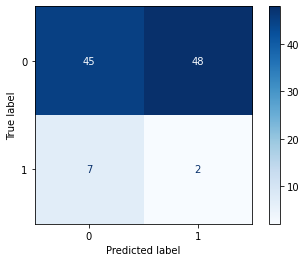

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

label = ["0", "1"]
cm = confusion_matrix(nus1_y_test, y_pred_nus1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [71]:
test_scaled.groupby('target').count()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
target,,,,,,,,
0.0,93,93,93,93,93,93,93,93
1.0,9,9,9,9,9,9,9,9


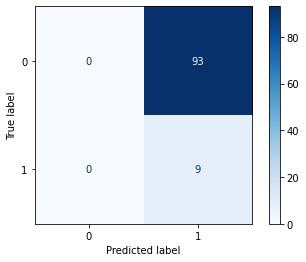

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

label = ["0", "1"]
cm = confusion_matrix(nus1_y_test, y_pred_org)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# **Accuracy**

In [77]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_X_train, nus1_y_train)
print('NUS1 Data')
print(knn.score(nus1_X_test, nus1_y_test))

#knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(nus1_org_X_train, nus1_org_y_train)
print('Without NUS!')
print(knn.score(nus1_X_test, nus1_y_test))

NUS1 Data
0.46078431372549017
Without NUS!
0.08823529411764706


In [80]:
f1_score(nus1_y_test, y_pred_nus1, average='macro')

0.3442431326709527

In [81]:
f1_score(nus1_y_test, y_pred_nus1, average='micro')

0.46078431372549017

In [82]:
f1_score(nus1_y_test, y_pred_nus1, average='weighted')

0.5719049747309795

In [83]:
f1_score(nus1_y_test, y_pred_nus1, average=None)

array([0.62068966, 0.06779661])

# **Plot Results**

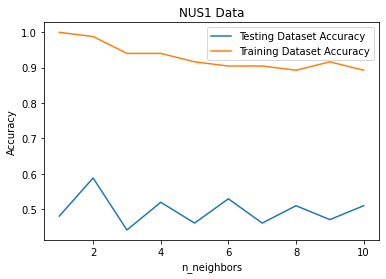

In [78]:
#NUS1 Data
neighbors = np.arange(1,11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(nus1_X_train, nus1_y_train)
  
  train_accuracy[i] = knn.score(nus1_X_train, nus1_y_train)
  test_accuracy[i] = knn.score(nus1_X_test, nus1_y_test)

plt.plot(neighbors, test_accuracy, label='Testing Dataset Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('NUS1 Data')
plt.show()

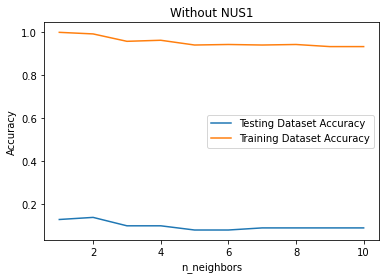

In [79]:
#Original Data (Without NUS1)
neighbors = np.arange(1,11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(nus1_org_X_train, nus1_org_y_train)
  
  train_accuracy[i] = knn.score(nus1_org_X_train, nus1_org_y_train)
  test_accuracy[i] = knn.score(nus1_X_test, nus1_y_test)

plt.plot(neighbors, test_accuracy, label='Testing Dataset Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Without NUS1')
plt.show()